In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [ ]:
print(os.listdir(r'/content/drive/MyDrive/data'))

['data credit.txt', 'train', 'unknown(test)', 'test']


In [ ]:
folder_benign_train = r'/content/drive/MyDrive/data/train/benign'
folder_malignant_train = r'/content/drive/MyDrive/data/train/malignant'

folder_benign_test = r'/content/drive/MyDrive/data/test/benign'
folder_malignant_test = r'/content/drive/MyDrive/data/test/malignant'

In [ ]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

In [ ]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
np.random.seed(20)
from sklearn.metrics import accuracy_score

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras import backend as K
from keras.optimizers import Adam  
from keras.callbacks import ReduceLROnPlateau


In [ ]:
# Convert labels into one hot encoding
#extra coding part is implemented here...just for encoding purpose
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
X_train = X_train/255
X_test = X_test/255

In [ ]:
# ResNet-50 Model building
input_shape = (224,224,3)
lr = 1e-5 # learning rate
epochs = 50
batch_size = 32

# set learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=1e-7)
# model = ResNet50(include_top = True,
#                 weights = None,
#                 input_tensor = None, 
#                 input_shape=input_shape,
#                 pooling='avg',
#                 classes=2)

In [ ]:
# //do code for vgg 16
from tensorflow.keras.applications.vgg16 import VGG16

vvg = VGG16(input_shape=(224,224, 3), include_top=False,weights = 'imagenet')
vvg.summary()


58889256/58889256 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
for layers in (vvg.layers):
    layers.trainable = False

In [ ]:
# Add the vvg convolutional base model
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Dense,Dropout
model2 = Sequential()
model2.add(vvg)

# Add new layers
model2.add(Flatten())
model2.add(Dense(4096 , activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(4096 , activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(4096, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(2, activation='softmax'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 4096)              1

In [ ]:
#First compile the model

model2.compile(optimizer = Adam(lr),
             loss = 'binary_crossentropy',
             metrics=['accuracy'])

In [ ]:
history = model2.fit(X_train, y_train, validation_split=0.2,
                   epochs = 50,
                   batch_size = batch_size,
                   verbose = 1,
                   callbacks = [learning_rate_reduction])

Epoch 1/50
66/66 [==============================] - 33s 302ms/step - loss: 0.6554 - accuracy: 0.6366 - val_loss: 0.5201 - val_accuracy: 0.8068 - lr: 1.0000e-05
Epoch 2/50
66/66 [==============================] - 14s 206ms/step - loss: 0.5106 - accuracy: 0.7713 - val_loss: 0.4453 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 3/50
66/66 [==============================] - 13s 198ms/step - loss: 0.4342 - accuracy: 0.8121 - val_loss: 0.4046 - val_accuracy: 0.8201 - lr: 1.0000e-05
Epoch 4/50
66/66 [==============================] - 13s 196ms/step - loss: 0.3896 - accuracy: 0.8330 - val_loss: 0.4014 - val_accuracy: 0.8220 - lr: 1.0000e-05
Epoch 5/50
66/66 [==============================] - 13s 202ms/step - loss: 0.3887 - accuracy: 0.8363 - val_loss: 0.4467 - val_accuracy: 0.8106 - lr: 1.0000e-05
Epoch 6/50
66/66 [==============================] - 13s 199ms/step - loss: 0.3677 - accuracy: 0.8463 - val_loss: 0.3792 - val_accuracy: 0.8201 - lr: 1.0000e-05
Epoch 7/50
66/66 [======================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


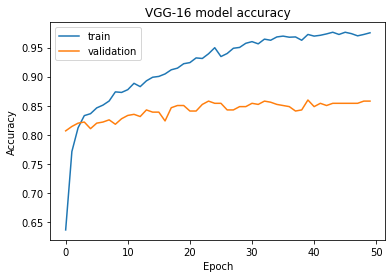

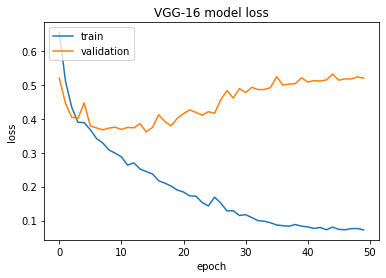

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG-16 model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG-16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred = model2.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))*100)

21/21 [==============================] - 5s 263ms/step
85.0


In [ ]:
y_test=np.argmax(y_test, axis=1)


In [ ]:
# save model
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)
    
# serialize weights to HDF5
model.save_weights("resnet50.h5")
print("Saved model to disk")

Confusion matrix, without normalization
[[298  62]
 [ 37 263]]


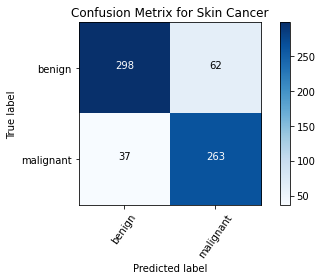

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Text(0.5, 1.0, 'VGG 16 Preformance')

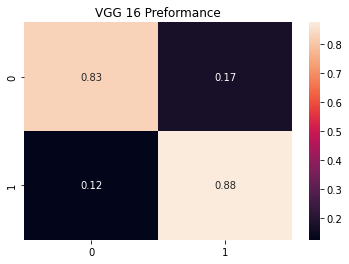

In [ ]:
# Confusion matrix based on XGBOOST
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True).set_title('VGG 16 Preformance')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       360
           1       0.81      0.88      0.84       300

    accuracy                           0.85       660
   macro avg       0.85      0.85      0.85       660
weighted avg       0.85      0.85      0.85       660



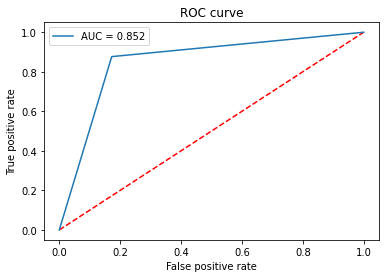

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(y_test, y_pred )
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()